In [21]:
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
from sklearn import preprocessing, cluster
import gspread, json
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import numpy as np

%matplotlib inline
pd.set_option('mode.chained_assignment', None)

with open('api_keys.json') as json_file:
    keys = json.load(json_file)

In [94]:
def get_gsheet(RANGENAME):
    ### Retrieve sheet data using OAuth credentials and Google Python API.
    SPREADSHEET_ID = keys["sheet"]
    scopes = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scopes)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                    range=RANGENAME).execute()
    df = gsheet2df(result)
    return df

def gsheet2df(gsheet):
    """ Converts Google sheet data to a Pandas DataFrame.
    Note: This script assumes that your data contains a header file on the first row!
    Also note that the Google API returns 'none' from empty cells - in order for the code
    below to work, you'll need to make sure your sheet doesn't contain empty cells,
    or update the code to account for such instances.
    """
    header = gsheet.get('values', [])[0]   # Assumes first line is header!
    values = gsheet.get('values', [])[1:]  # Everything else is data.
    if not values:
        print('No data found.')
    else:
        all_data = []
        for col_id, col_name in enumerate(header):
            column_data = []
            for row in values:
                column_data.append(row[col_id])
            ds = pd.Series(data=column_data, name=col_name)
            all_data.append(ds)
        df = pd.concat(all_data, axis=1)
        return df
    
def df_clean(df, names=None):
    # Get the dataframe, drop all the duplicates and specified columns (in a string array)
    df_cleaned = df.drop_duplicates()
    if names is not None: # drop columns if they are not useful
        df_cleaned.drop(columns=names, inplace=True)
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

def sheet_timestamp(df, form):
    # parse the date string into datetime object using the specified format
    df['date'] = df['date'].apply(lambda x: 
                        datetime.strptime(x,form))
    df['timestamp'] = df['date'].apply(lambda x: datetime.timestamp(x)) #timestamp in the unix format
    df.sort_values(by=['timestamp'], inplace=True)
    df = df.reset_index(drop=True)
    return df

def to_numeric(df, names):
    # ensure the specified columns are numeric values for data plotting
    for name in names:
        df[name] = pd.to_numeric(df[name])
    return df

def standardising(data):
    #standardising the data array
    if (max(data)-min(data)) < 0.000001:
        return data
    else:
        scale = 1/(max(data)-min(data))
        data_scaled = scale*(data - min(data))
        return data_scaled

def data_standardising(df, names=None):
    if names is None:
        for key in df.keys():
            if df[key].dtype == 'int64' or df[key].dtype == 'float64':
                df[key+"_std"] = standardising(df[key])
    else:
        for name in names:
            if df[name].dtype == 'int64' or df[name].dtype == 'float64':
                df[name+"_std"] = standardising(df[name])
    return df

def adjust_time(df, base):
    df['timestamp'] = df['timestamp']-base
    df = df[df['timestamp']>=0]
    return df

def value_change(df, target):
    for i in range(len(df[target])):
        if i == 0:
            df.at[i, 'change'] = 0
#             print(df.iloc[i]['changed'])
        else:
            df.at[i, 'change'] = df.iloc[i]['value'] - df.iloc[i-1]['value']
    return df

# 1. Preprocessing
Getting the data from cloud storage and clean it up for analysis

In [23]:
## Get all four datasets from the google sheets used for data storage

HSI = get_gsheet("HSI")
HKD = get_gsheet("HKD")
WEATHER_HKO = get_gsheet("Weather")
WEATHER_DS = get_gsheet("Weather2")

print("df sizes before cleaning: ")
print("HSI: ", HSI.shape)
print("HKD: ", HKD.shape)
print("Weather HKO: ", WEATHER_HKO.shape)
print("Weather DS: ", WEATHER_DS.shape)

## Both weather APIs uses something known as "icon"
HKO_icons = {
    50: 'Sunny',
    51: 'Sunny Periods',
    52: 'Sunny Intervals',
    53: 'Sunny Periods with a Few Showers',
    54: 'Sunny Intervals with Showers',
    60: 'Cloudy',
    61: 'Overcast',
    62: 'Light Rain',
    63: 'Rain',
    64: 'Heavy Rain',
    65: 'Thunderstorms',
    70: 'Fine (Night)',
    71: 'Fine (Night)',
    72: 'Fine (Night)',
    73: 'Fine (Night)',
    74: 'Fine (Night)',
    75: 'Fine (Night)',
    76: 'Mainly Cloudy (Night)',
    77: 'Mainly Fine (Night)',
    80: 'Windy',
    81: 'Dry',
    82: 'Humid',
    83: 'Fog',
    84: 'Mist',
    85: 'Haze',
    90: 'Hot',
    91: 'Warm',
    92: 'Cool',
    93: 'Cold'
}
# Map these two different sets of icons together
DS_map = {
    'clear-day': 'Sunny',
    'clear-night': 'Mainly Fine (Night)',
    'rain': 'Rain',
    'snow': 'Snow',
    'sleet': 'Sleet',
    'wind': 'Windy',
    'fog': 'Fog',
    'cloudy': 'Overcast',
    'partly-cloudy-day': 'Cloudy',
    'partly-cloudy-night': 'Mainly Cloudy (Night)' 
}

df sizes before cleaning: 
HSI:  (8255, 6)
HKD:  (8781, 5)
Weather HKO:  (381, 5)
Weather DS:  (441, 5)


In [95]:
# Cleaning out the duplicates and data arrays that are not useful to analysis
HSI_cleaned = df_clean(HSI,['2. high', '3. low', '5. volume'])
HKD_cleaned = df_clean(HKD, ['2. high', '3. low'])
WHKO_cleaned = df_clean(WEATHER_HKO)
WDS_cleaned = df_clean(WEATHER_DS)

print("df sizes after cleaning: ")
print("HSI: ", HSI_cleaned.shape)
print("HKD: ", HKD_cleaned.shape)
print("Weather HKO: ", WHKO_cleaned.shape)
print("Weather DS: ", WDS_cleaned.shape)

df sizes after cleaning: 
HSI:  (2729, 3)
HKD:  (4420, 3)
Weather HKO:  (77, 5)
Weather DS:  (430, 5)


In [25]:
# adjusting the timestamp columns of all data
form = '%Y-%m-%d %H:%M:%S'
sheet_timestamp(HSI_cleaned, form)
sheet_timestamp(HKD_cleaned, form)
sheet_timestamp(WHKO_cleaned, form)
sheet_timestamp(WDS_cleaned, form)

# making sure the data are numbers
HSI_cleaned = to_numeric(HSI_cleaned, ['1. open', '4. close'])
HKD_cleaned = to_numeric(HKD_cleaned, ['1. open', '4. close'])
WHKO_cleaned = to_numeric(WHKO_cleaned, ['temperature', 'humidity', 'rainfall', 'icon'])
WDS_cleaned = to_numeric(WDS_cleaned, ['temperature', 'humidity', 'rainfall'])

# open and close per minute data is still not that useful, the average is more representative:
HSI_cleaned['value'] = (HSI_cleaned['1. open']+HSI_cleaned['4. close'])/2
HSI_cleaned.drop(columns=['1. open', '4. close'], inplace=True)
HKD_cleaned['value'] = (HKD_cleaned['1. open']+HKD_cleaned['4. close'])/2
HKD_cleaned.drop(columns=['1. open', '4. close'], inplace=True)

In [26]:
# when making financial decisions, the change in prices is often more important than the absolute value
value_change(HSI_cleaned, 'value')
value_change(HKD_cleaned, 'value')

# mapping the weather icons for consistency
WHKO_cleaned['icon'].replace(HKO_icons, inplace=True)
WDS_cleaned['icon'].replace(DS_map, inplace=True)
WHKO_cleaned.head()

,date,temperature,humidity,rainfall,icon,timestamp
0,2019-12-31 07:00:00,20,90,0,Cloudy,1.577776e+09
1,2019-12-31 08:00:00,20,88,0,Cloudy,1.577779e+09
2,2019-12-31 09:00:00,20,88,0,Cloudy,1.577783e+09
3,2019-12-31 10:00:00,20,89,0,Cloudy,1.577786e+09
4,2019-12-31 11:00:00,19,87,0,Cloudy,1.577790e+09


In [29]:
# standardising data
data_standardising(HSI_cleaned, ['value', 'change'])
data_standardising(HKD_cleaned, ['value', 'change'])
data_standardising(WHKO_cleaned, ['temperature', 'humidity', 'rainfall'])
data_standardising(WDS_cleaned, ['temperature', 'humidity', 'rainfall'])
HSI_cleaned.head()

,date,timestamp,value,change,value_std,change_std
0,2019-12-30 09:31:00,1.577698e+09,28223.010,0.000,0.352944,0.521665
1,2019-12-30 09:32:00,1.577698e+09,28208.170,-14.840,0.338230,0.497977
2,2019-12-30 09:33:00,1.577698e+09,28203.070,-5.100,0.333173,0.513524
3,2019-12-30 09:34:00,1.577698e+09,28199.595,-3.475,0.329727,0.516118
4,2019-12-30 09:35:00,1.577698e+09,28198.300,-1.295,0.328443,0.519598


# 2. Basic Time Series Data Analysis
Basic analysis and visualisation to get a better understanding on the shape and nature of the data

## 2.1 Visualising
Plotting each of the data to better understand the nature of the data, and try smoothing it out with moving average

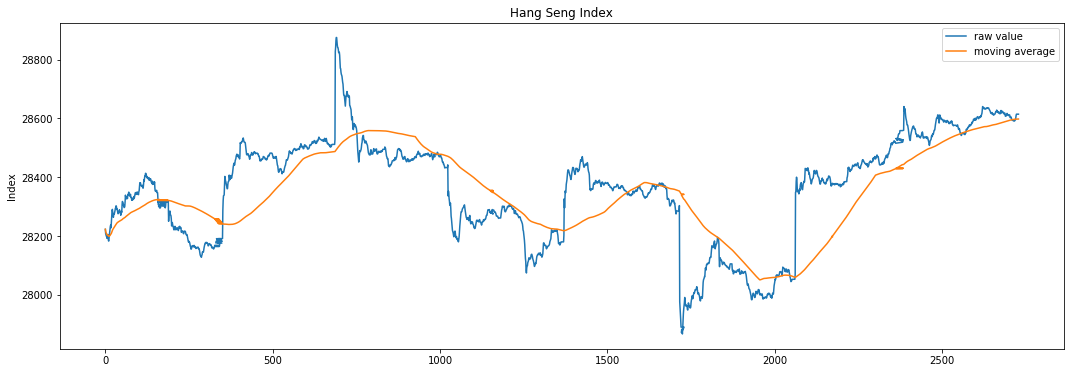

In [30]:
rolling_mean = HSI_cleaned['value'].rolling(window=240, min_periods=1).mean()
fig1 = plt.figure(figsize = (18,6))
plot = plt.plot(HSI_cleaned['value'], label = "raw value")
plot = plt.plot(rolling_mean, label = "moving average")
plt.legend()
plt.ylabel("Index")
plt.title("Hang Seng Index")
plt.show()

However there are significant gaps in the weather data, making such analysis less useful.

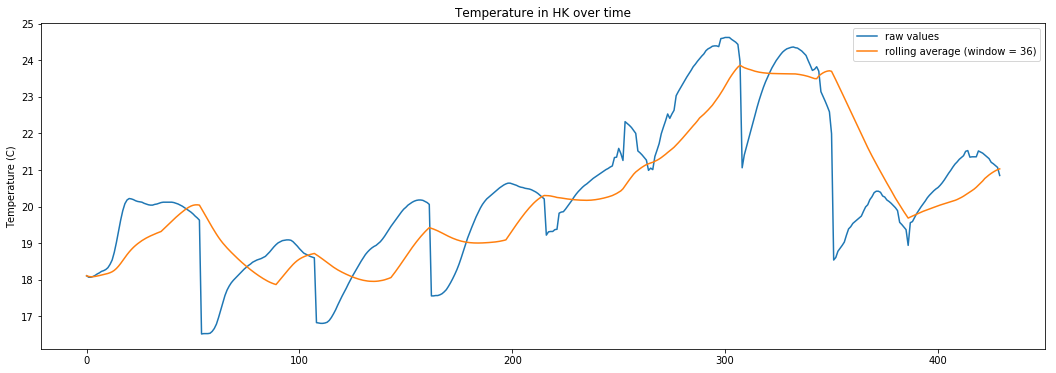

In [31]:
rolling_mean = WDS_cleaned['temperature'].rolling(window=36, min_periods=1).mean()
fig2 = plt.figure(figsize = (18,6))
plt.plot(WDS_cleaned['temperature'], label = "raw values")
plt.plot(rolling_mean, label = "rolling average (window = 36)")
plt.title("Temperature in HK over time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

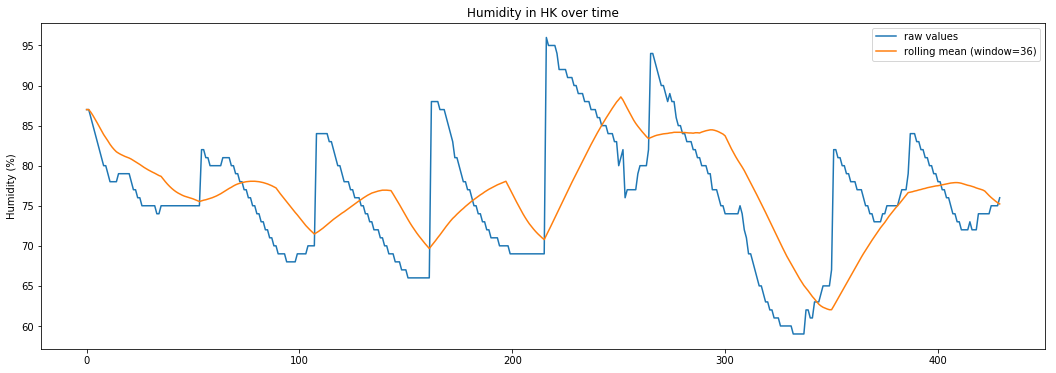

In [32]:
rolling_mean = WDS_cleaned['humidity'].rolling(window=36, min_periods=1).mean()
# rolling_std = WDS_cleaned['humidity'].rolling(window = 36).std()

fig3 = plt.figure(figsize = (18,6))
plt.plot(WDS_cleaned['humidity'], label = "raw values")
plt.plot(rolling_mean, label = "rolling mean (window=36)")
plt.title("Humidity in HK over time")
plt.ylabel("Humidity (%)")
plt.legend()
plt.show()

Hence we can notice that the weather data is as expectedly weakly cyclic, as it corresponds to the sunlight hours. However the Hang Seng Index does not show any recognisable behaviour.

# 3. Further Data Analysis
Data cross correlation etc

## 3.1 Further Processing

In [33]:
# find the lowest common starting point of the data
base_time = max(min(HSI_cleaned['timestamp']),min(HKD_cleaned['timestamp']),min(WHKO_cleaned['timestamp']),min(WDS_cleaned['timestamp']))
# map the timestamps according to this start to reduce the size of the numbers
adjust_time(HSI_cleaned, base_time)
adjust_time(HKD_cleaned, base_time)
adjust_time(WHKO_cleaned, base_time)
adjust_time(WDS_cleaned, base_time)
HSI_cleaned.head()

,date,timestamp,value,change,value_std,change_std
0,2019-12-30 09:31:00,-77340.0,28223.010,0.000,0.352944,0.521665
1,2019-12-30 09:32:00,-77280.0,28208.170,-14.840,0.338230,0.497977
2,2019-12-30 09:33:00,-77220.0,28203.070,-5.100,0.333173,0.513524
3,2019-12-30 09:34:00,-77160.0,28199.595,-3.475,0.329727,0.516118
4,2019-12-30 09:35:00,-77100.0,28198.300,-1.295,0.328443,0.519598


In [34]:
# the financial data also has a higher sampled frequency and volitility, a moving average will help with analysis
HSI_cleaned['moving_average'] = HSI_cleaned['value'].rolling(10,min_periods=1).mean()
HKD_cleaned['moving_average'] = HKD_cleaned['value'].rolling(10,min_periods=1).mean()
# merge the useful dataframes using the common timestamps
merged = pd.merge(HSI_cleaned, WDS_cleaned[['timestamp', 'temperature', 'humidity', 'icon', 'temperature_std', 'humidity_std']], on="timestamp")
data_standardising(merged, ['moving_average'])
merged.head()

,date,timestamp,value,change,value_std,change_std,moving_average,temperature,humidity,icon,temperature_std,humidity_std,moving_average_std
0,2019-12-31 09:40:00,9600.0,28234.37990,-24.12010,0.364217,0.483164,28268.009570,19.63,79,Overcast,0.383951,0.540541,0.388045
1,2019-12-31 09:50:00,10200.0,28233.18065,3.33105,0.363028,0.526982,28232.416500,19.89,79,Overcast,0.416049,0.540541,0.350712
2,2019-12-31 10:00:00,10800.0,28218.90500,-3.74050,0.348874,0.515695,28223.455140,20.08,79,Overcast,0.439506,0.540541,0.341312
3,2019-12-31 10:10:00,11400.0,28214.94530,2.04490,0.344947,0.524929,28225.795995,20.18,79,Overcast,0.451852,0.540541,0.343767
4,2019-12-31 10:20:00,12000.0,28216.39450,-0.83595,0.346384,0.520331,28214.549705,20.22,79,Overcast,0.456790,0.540541,0.331971


## 3.2 Correlation Analysis

In [90]:
# Autocorrelation for the relevant series
hsi_auto = []
chg_auto = []
tem_auto = []
hum_auto = []
for i in range(merged.shape[0]):
    hsi_auto.append(merged['value'].autocorr(lag=i))
    chg_auto.append(merged['change'].autocorr(lag=i))
    tem_auto.append(merged['temperature'].autocorr(lag=i))
    hum_auto.append(merged['humidity'].autocorr(lag=i))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Text(0.5,1,'Humidity Autocorrelation')

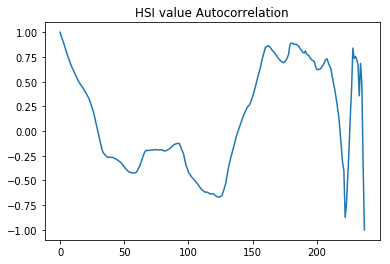

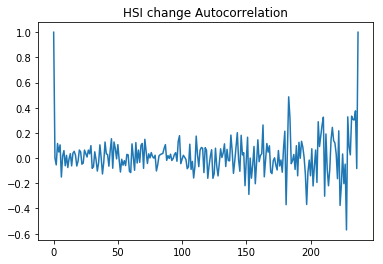

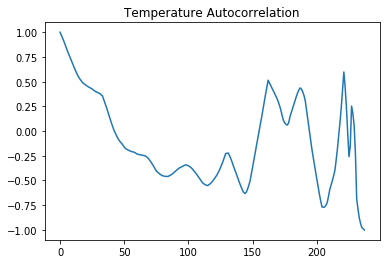

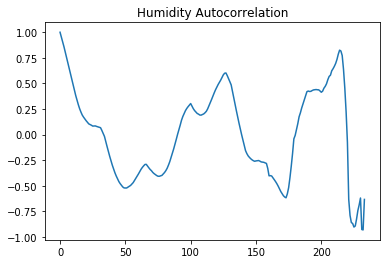

In [93]:
plt.figure()
plt.plot(hsi_auto)
plt.title('HSI value Autocorrelation')
plt.figure()
plt.plot(chg_auto)
plt.title('HSI change Autocorrelation')
plt.figure()
plt.plot(tem_auto)
plt.title('Temperature Autocorrelation')
plt.figure()
plt.plot(hum_auto)
plt.title('Humidity Autocorrelation')

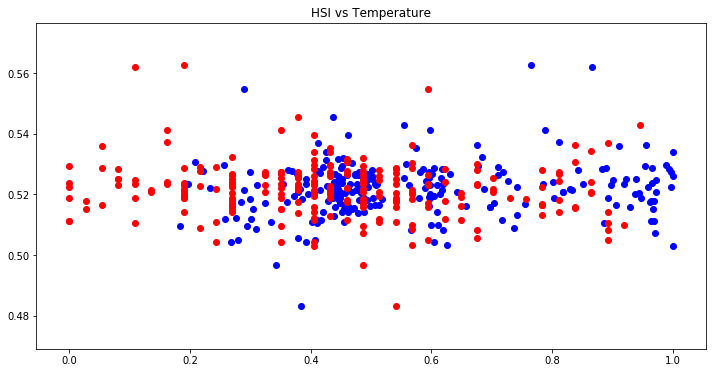

In [36]:
fig = plt.figure(figsize = (12,6))
plt.scatter(merged['temperature_std'], merged['change_std'], c='b', label = 'temperature')
plt.scatter(merged['humidity_std'], merged['change_std'], c='r', label = 'temperature')
plt.title('HSI vs Temperature')
plt.show()

                            OLS Regression Results                            
Dep. Variable:     moving_average_std   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     71.59
Date:                Sun, 12 Jan 2020   Prob (F-statistic):           2.76e-15
Time:                        22:47:40   Log-Likelihood:                 85.161
No. Observations:                 239   AIC:                            -166.3
Df Residuals:                     237   BIC:                            -159.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7415      0.032     

<Figure size 1296x432 with 0 Axes>

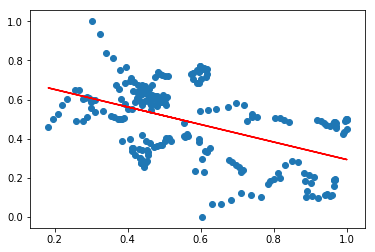

In [37]:
model = smf.ols(formula='moving_average_std~temperature_std', data=merged).fit()
print(model.summary())
b, a = model.params  # extracting model parameters
y_predicted = a * merged['temperature_std'] + b  # calculating the line of best fit
fig4 = plt.figure(figsize = (18,6))
plt.figure()
plt.plot(merged['temperature_std'], y_predicted, 'r-')
plt.scatter(merged['temperature_std'], merged['moving_average_std'])
plt.show()

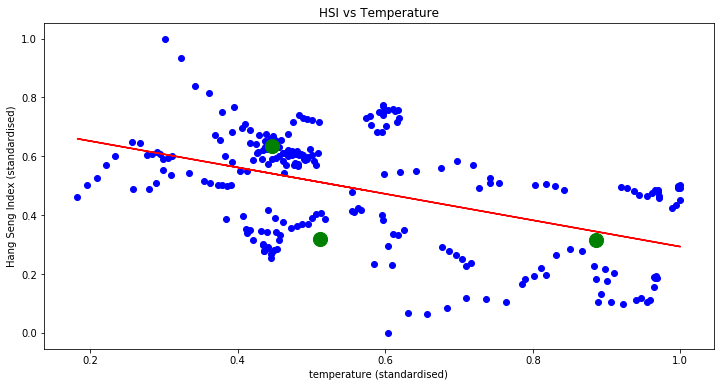

In [38]:
temp_kmean = cluster.KMeans(n_clusters=3)
temp_kmean.fit(merged[['temperature_std', 'moving_average_std']])
temp_kmean.cluster_centers_

fig5 = plt.figure(figsize = (12,6))
plt.plot(merged['temperature_std'], y_predicted, 'r-')
plt.scatter(merged['temperature_std'], merged['moving_average_std'], c='b')
for i in range(temp_kmean.cluster_centers_.shape[0]):
    plt.scatter(temp_kmean.cluster_centers_[i][0],temp_kmean.cluster_centers_[i][1], s=200, c='g')
plt.xlabel('temperature (standardised)')
plt.ylabel('Hang Seng Index (standardised)')
plt.title('HSI vs Temperature')
plt.show()


                            OLS Regression Results                            
Dep. Variable:     moving_average_std   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     7.591
Date:                Sun, 12 Jan 2020   Prob (F-statistic):            0.00632
Time:                        22:47:42   Log-Likelihood:                 57.387
No. Observations:                 239   AIC:                            -110.8
Df Residuals:                     237   BIC:                            -103.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4181      0.028     15.011   

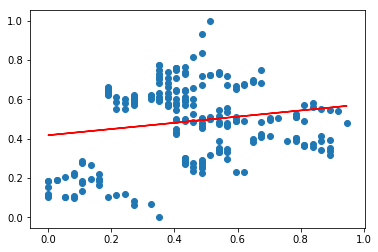

In [39]:
model = smf.ols(formula='moving_average_std~humidity_std', data=merged).fit()
print(model.summary())
b, a = model.params  # extracting model parameters
y_predicted = a * merged['humidity_std'] + b  # calculating the line of best fit
plt.figure()
plt.plot(merged['humidity_std'], y_predicted, 'r-')
plt.scatter(merged['humidity_std'], merged['moving_average_std'])
plt.show()

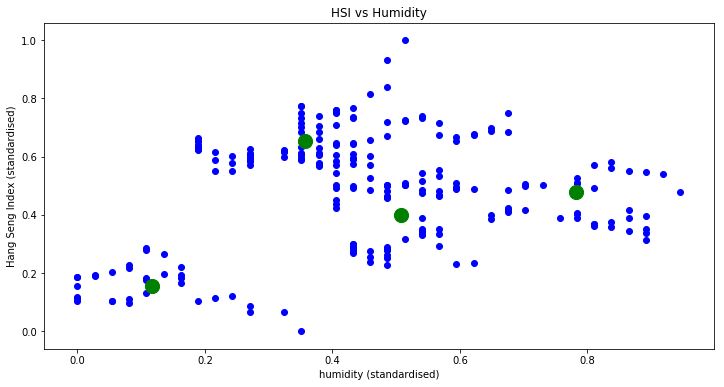

In [40]:
temp_kmean = cluster.KMeans(n_clusters=4)
temp_kmean.fit(merged[['humidity_std', 'moving_average_std']])
temp_kmean.cluster_centers_
fig5 = plt.figure(figsize = (12,6))
# plt.plot(merged['humidity_std'], y_predicted, 'r-')
plt.scatter(merged['humidity_std'], merged['moving_average_std'], c='b')
for i in range(temp_kmean.cluster_centers_.shape[0]):
    plt.scatter(temp_kmean.cluster_centers_[i][0],temp_kmean.cluster_centers_[i][1], s=200, c='g')
plt.xlabel('humidity (standardised)')
plt.ylabel('Hang Seng Index (standardised)')
plt.title('HSI vs Humidity')
plt.show()

Both clustering analysis does not work as well as intended, however it seems like there are some clustering behaviour. At the same time, instead of predicting

In [82]:
icons = []
for i in range(len(merged['icon'].unique())):
    icons.append(merged[merged['icon']== merged['icon'].unique()[i]])
    
for i in icons:
    print(i.iloc[0]['icon'])

Overcast
Cloudy
Sunny


                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.274
Date:                Mon, 13 Jan 2020   Prob (F-statistic):             0.0398
Time:                        04:49:39   Log-Likelihood:                -752.16
No. Observations:                 239   AIC:                             1508.
Df Residuals:                     237   BIC:                             1515.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.9826      1.065     

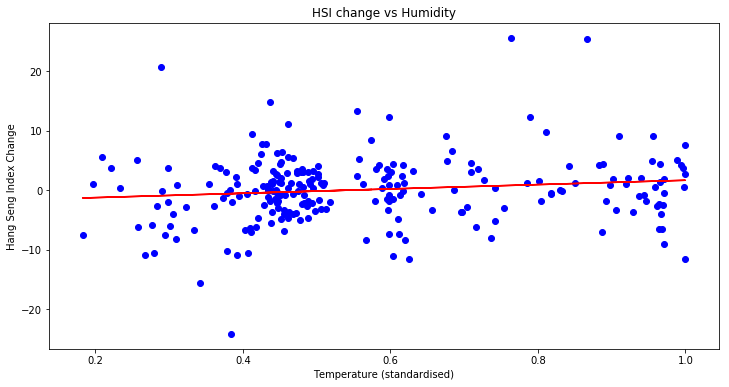

In [71]:
model = smf.ols(formula='change~temperature_std', data=merged).fit()
print(model.summary())
b, a = model.params  # extracting model parameters
y_predicted = a * merged['temperature_std'] + b  # calculating the line of best fit
fig6 = plt.figure(figsize = (12,6))
plt.plot(merged['temperature_std'], y_predicted, 'r-')
plt.scatter(merged['temperature_std'], merged['change'], c='b')
plt.xlabel('Temperature (standardised)')
plt.ylabel('Hang Seng Index Change')
plt.title('HSI change vs Humidity')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.644
Date:                Mon, 13 Jan 2020   Prob (F-statistic):              0.105
Time:                        04:49:41   Log-Likelihood:                -752.97
No. Observations:                 239   AIC:                             1510.
Df Residuals:                     237   BIC:                             1517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2895      0.827      1.560   

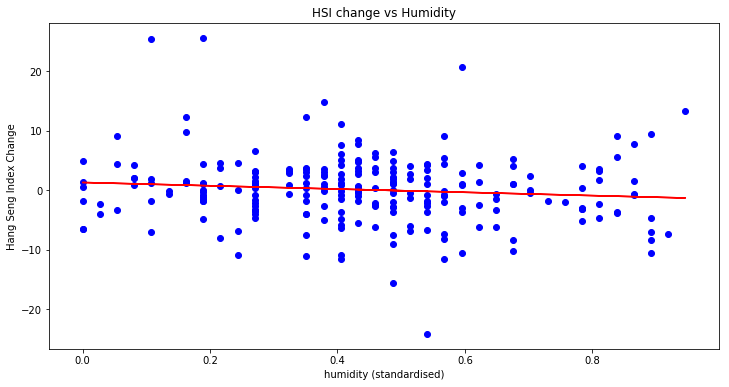

In [72]:
model = smf.ols(formula='change~humidity_std', data=merged).fit()
print(model.summary())
b, a = model.params  # extracting model parameters
y_predicted = a * merged['humidity_std'] + b  # calculating the line of best fit
fig7 = plt.figure(figsize = (12,6))
plt.plot(merged['humidity_std'], y_predicted, 'r-')
plt.scatter(merged['humidity_std'], merged['change'], c='b')
plt.xlabel('humidity (standardised)')
plt.ylabel('Hang Seng Index Change')
plt.title('HSI change vs Humidity')
plt.show()